In [13]:
from src.utils import config_from_id, get_ckpt_path
from hydra.utils import instantiate
from src.lightning_modules import DSB

def load_dsb_model(experiment_id : str, dsb_iteration : int) -> DSB:
    config = config_from_id(experiment_id)
    model_config = config['model']
    forward_model = instantiate(model_config['forward_model'])
    backward_model = instantiate(model_config['backward_model'])
    encoder_decoder = instantiate(model_config['encoder_decoder'])
    ckpt_path = get_ckpt_path(experiment_id, last=False, filename=f"DSB_iteration_{dsb_iteration}.ckpt")
    model = DSB.load_from_checkpoint(ckpt_path, forward_model=forward_model, backward_model=backward_model, encoder_decoder=encoder_decoder)
    return model

Failed to get config from wandb for 180425125453 in kommodeskab-danmarks-tekniske-universitet-dtu. Trying next.
Found experiment 180425125453 in bjornsandjensen-dtu.


In [1]:
from src.utils import load_dsb_model

model = load_dsb_model('180425125453', 1)

/work3/s214630/Latent-DSB/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:speechbrain.utils.quirks:Applied quirks (see `speechbrain.utils.quirks`): [allow_tf32, disable_jit_profiling]
INFO:speechbrain.utils.quirks:Excluded quirks specified by the `SB_DISABLE_QUIRKS` environment (comma-separated list): []


Failed to get config from wandb for 180425125453 in kommodeskab-danmarks-tekniske-universitet-dtu. Trying next.
Found experiment 180425125453 in bjornsandjensen-dtu.


In [ ]:
import torch

trajectories = []

for _ in range(128):
    x0 = torch.randn((2,))
    x1 = torch.randn((2,))

    # make a linear interpolation
    t = torch.linspace(0, 1, 101).unsqueeze(1)
    trajectory = x0 * (1 - t) + x1 * t

    deviation_direction = torch.tensor([-1, 1])
    trajectory += 0.1 * t * (1 -t) * deviation_direction
    trajectory += torch.randn_like(trajectory) * 0.001
    trajectories.append(trajectory)
    
trajectories = torch.stack(trajectories).permute(1,0,2)

In [94]:
from torch import Tensor

def calculate_curvature_displacement(trajectories : Tensor, timeschedule : Tensor) -> tuple[Tensor, Tensor]:
    # trajectories.shape = (trajectory_length, batch_size, ...)
    timeschedule = timeschedule.unsqueeze(1)
    batch_size = trajectories.shape[1]
    C_t_list = []
    for i in range(batch_size):
        trajectory = trajectories[:, i]
        x0 = trajectory[0]
        x1 = trajectory[-1]
        dx = trajectory[1:] - trajectory[:-1]
        dt = timeschedule[1:] - timeschedule[:-1]
        C_t = (x1 - x0) - dx / dt
        C_t = C_t.norm(dim=1)
        C_t_list.append(C_t)
    C_t = torch.stack(C_t_list, dim=0)
    C_t_mean, C_t_std = C_t.mean(dim=0), C_t.std(dim=0)
    return C_t_mean, C_t_std

In [96]:
C_t_mean, C_t_std = calculate_curvature_displacement(trajectories, t.flatten())

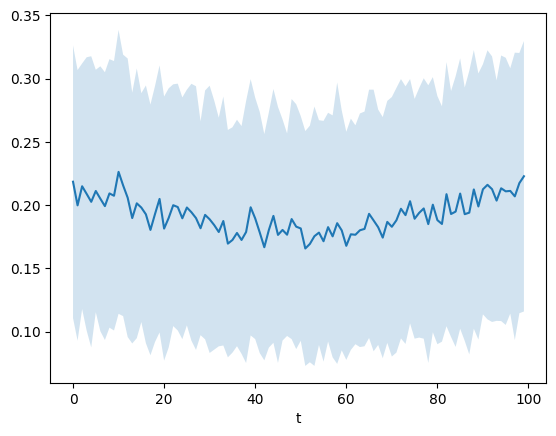

In [97]:
import matplotlib.pyplot as plt
plt.plot(C_t_mean)
plt.fill_between(range(len(C_t_mean)), C_t_mean - C_t_std, C_t_mean + C_t_std, alpha=0.2)
plt.xlabel('t')
plt.show()